# Image Detection
This project is to train a deep learning model to detecta and classify road sign in indian road.

Dataset used for this project is `Indian Traffic Sign Dataset` from Kaggle : https://www.kaggle.com/datasets/neelpratiksha/indian-traffic-sign-dataset?resource=download

In [1]:
# Loading data from drive(mounting the google drive to our project)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Folder containing all the images in folder format
data_path = '/content/drive/MyDrive/project/traffic-road-sign-detection/indian-traffic-sign-dataset/Images'

In [3]:
# csv file contains the folder number mapped to class name
labels_path = '/content/drive/MyDrive/project/traffic-road-sign-detection/indian-traffic-sign-dataset/traffic_sign.csv'

In [4]:
4# Importing important laibaries
import pandas as pd
import numpy as np

import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from collections import Counter

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [5]:
labels_df = pd.read_csv(labels_path)
labels_df.head(5)

,ClassId,Name
0,0,Give way
1,1,No entry
2,2,One-way traffic
3,3,One-way traffic
4,4,No vehicles in both directions


In [6]:
# Data Transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5],
        std=[0.5])
])

In [7]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

###The following custom dataset class is created because I was facing problem while loading the dataset as a dataloader for my model. The labels and the images were not matching when plain datasets.ImageFolder was used over the dataset

# Temporary note: change the getitem function to extract the folder name rather then extracting the number in file name, because there are few images having wrong names

In [8]:
from PIL import Image
import os
import re

# Define a custom dataset class
class CustomTrafficSignDataset(Dataset):
    def __init__(self, root_dir, transform=None, split_percentage=0.8, train=True):
        # Create an ImageFolder dataset using torchvision
        self.dataset = datasets.ImageFolder(root=root_dir, transform=transform)

        self.transform = transform
        self.train = train
        self.split_percentage = split_percentage

        # Calculate split index based on split percentage
        split_index = int(len(self.dataset) * self.split_percentage)

        if self.train:
            self.data = self.dataset.imgs[:split_index]
        else:
            self.data = self.dataset.imgs[split_index:]

    def __len__(self):
        # Return the length of the dataset
        return len(self.data)

    def __getitem__(self, idx):
        img_path, _ = self.data[idx]  # Get the image path and ignore the label from ImageFolder

        # Extract label from the folder name (which is just a number)
        folder_name = os.path.basename(os.path.dirname(img_path))
        label = int(folder_name)

        img = Image.open(img_path).convert('L')  # Convert to grayscale

        if self.transform:
            img = self.transform(img)

        return img, label

    # def __getitem__(self, idx):
    #     img_path = self.data[idx][0]
    #     folder_name = os.path.basename(os.path.dirname(img_path))

    #     # Extracting the first numeric sequence from the folder name
    #     # using regular expressing
    #     label_match = re.search(r'\d+', folder_name)
    #     # Default to zero if no numeric value is found
    #     label = int(label_match.group()) if label_match else 0

    #     img = Image.open(img_path).convert('L') # convert to gray scale

    #     if self.transform:
    #         img=self.transform(img)

    #     return img, label

In [9]:
# Creating an instance of custom dataset for training
train_dataset = CustomTrafficSignDataset(root_dir=data_path,
                                         transform=transform,
                                         split_percentage=0.8,
                                         train=True)
# Creating an instance of custom dataset for validation
validation_dataset = CustomTrafficSignDataset(root_dir=data_path,
                                              transform=transform,
                                              split_percentage=0.8,
                                              train=False)
len(train_dataset), len(validation_dataset)

(9326, 2332)

In [10]:
BATCH_SIZE = 32
# Creating training data loader
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
# Creating validation data loader
validation_loader = DataLoader(validation_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)
len(train_loader), len(validation_loader)

(292, 73)

class_info: 13    Axle weight limit
Name: Name, dtype: object

Class name: Axle weight limit
Random Label: 13


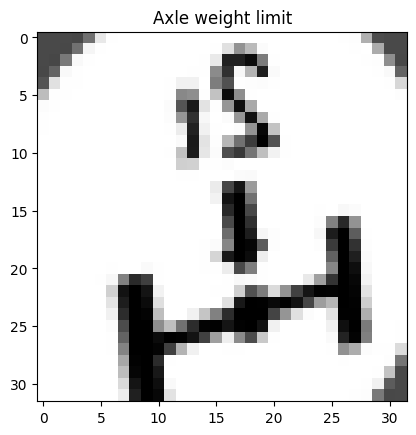

In [11]:
# Get a batch of data from the train_loader
images, labels = next(iter(train_loader))

# Choose a random index within the batch
random_index_within_batch = 0  # Adjust as needed

# Extract the random image and label
random_image = images[random_index_within_batch]
random_label = labels[random_index_within_batch]

# Convert the PyTorch tensor to a NumPy array for visualization
random_image_np = random_image.squeeze().numpy()

# Denormalize the image
mean = 0.5
std = 0.5
sample_image = random_image_np * std + mean

class_label = random_label.item()
class_info = labels_df[labels_df['ClassId']==class_label]['Name']
print(f"class_info: {class_info}\n")
class_name = class_info.iloc[0]
print(f"Class name: {class_name}")

# Print the label and display the image
print(f'Random Label: {class_label}')
plt.imshow(sample_image, cmap='gray')  # Specify cmap for grayscale
plt.title(class_name)
plt.show()

In [12]:
# Checking device
print(next(iter(train_loader))[0].device)

cpu


# Model 1: Convolutional Neural Network model for classification
Model Source : https://poloclub.github.io/cnn-explainer/

In [13]:
# Creating CNN model
class TrafficSignalClassificationModelV1(nn.Module):
    """
    Model architecture is inspired from TineyVGG model from
    CNN explainer website
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,  # The kernel size 3 is equivalent to (3, 3) touple, same as 3x3 matrix
                      stride=1,
                      padding=1),      # kernel_size, stride, padding are the Conv2d hyperparameters
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 8 * 8,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(f"Output shape of conv_block_1: {x.shape}")
        x = self.conv_block_2(x)
        # print(f"Output shape of conv_block_2: {x.shape}")
        x = self.classifier(x)
        # print(f"Output shape of clsssifier: {x.shape}")
        return x

In [14]:
# Running a forward pass to figure out the final linear layer in_features shapes
dummy_traffic_symbol_model = TrafficSignalClassificationModelV1(input_shape=1,
                                                          hidden_units=10,
                                                          output_shape=len(labels_df['ClassId'])).to(device)
next(dummy_traffic_symbol_model.parameters()).device

device(type='cpu')

In [15]:
random_image.unsqueeze(dim=0).shape

torch.Size([1, 1, 32, 32])

In [16]:
# Running sample image through a forward pass
dummy_traffic_symbol_model(random_image.unsqueeze(dim=0).to(device))

tensor([[ 0.0369, -0.0565,  0.0113,  0.0556,  0.0946, -0.0137, -0.0317, -0.0052,
          0.0007,  0.0609,  0.0503, -0.0015,  0.0298, -0.0426, -0.0306, -0.0193,
          0.0104, -0.0162,  0.0942, -0.0168, -0.0108, -0.0313,  0.0436,  0.0538,
         -0.0189,  0.0166,  0.0123, -0.0379, -0.0256, -0.0804,  0.0592,  0.0514,
         -0.0454, -0.0157, -0.0513, -0.0089,  0.0252,  0.0638,  0.0453, -0.0036,
         -0.0453, -0.0580,  0.0501, -0.0235,  0.0243,  0.0062, -0.0496, -0.0085,
         -0.0140,  0.0363, -0.0121, -0.0265,  0.0785, -0.0089,  0.0332,  0.0122,
          0.0489,  0.0181, -0.0105]], grad_fn=<AddmmBackward0>)

## The final layer input feature shape should be `hidden_units*8*8`

In [17]:
# Total number of classes
total_classes = len(labels_df['ClassId'])
print(f"Total classes : {total_classes}")

Total classes : 59


In [18]:
# Inidializing our model
SEED_VALUE = 50
torch.manual_seed(SEED_VALUE)

sign_class_model_v1 = TrafficSignalClassificationModelV1(input_shape=1,
                                                      hidden_units=10,
                                                      output_shape=total_classes).to(device)
sign_class_model_v1

TrafficSignalClassificationModelV1(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=640, out_features=59, bias=True)
  )
)

In [ ]:
sign_class_model_v1.state_dict()

## Setting up loss function and optimizer for our model

In [20]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(params=sign_class_model_v1.parameters(),
                            lr=0.1)

In [21]:
# Accuracy function for evaluation
def accuracy_fn(y_true, y_pred):
    """
    Calculates accuracy between true labels and predicted labels
    Args:
      y_true (torch.Tensor): Ground Truth labels
      y_pred (torch.Tensor): Model predictions
    Returns:
      Accuracy value in parcentage % (torch.float)
    """
    correct_values = torch.eq(y_true, y_pred).sum().item()
    accuracy = (correct_values / len(y_true)) * 100
    return accuracy

## Creating training step function for training our model in batches

Steps:
1. Loop through epochs.
2. Loop through training batches, perform training steps

In [22]:
# Training Loop function
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device=device):
    """
    performs training loop to learn on data loader
    """
    train_loss, train_acc = 0, 0

    # Put model in training mode
    model.train()

    # Loop through training batches
    for batch, (X, y) in enumerate(data_loader):
        # Put data into target device
        X, y = X.to(device), y.to(device)

        print("before model forward train")
        # Forward pass
        y_pred = model(X)
        print("after model forward train")

        # Calculate loss and accuracy (per batch)
        loss = loss_fn(y_pred, y)
        # accumulating training loss and traiing accuracy accross epochs
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # going from logits --> prediction labels

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step (Update the model parameter once per batch)
        optimizer.step()

    # Divide total train loss and accuracy by length of train dataloader to get the average value
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    # Print vervose
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

## Creating a validation step function for validating model on unseen data
Steps:
1. Put model to inference mode
2. Loop through testing batches, perform testing steps, calculate test loss per batch

In [23]:
# Testing / Validation loop
def val_step(model: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             accuracy_fn,
             device: torch.device=device):
    """
    This function performs a validation loop step over our dataloader
    """
    val_loss, val_acc = 0, 0

    # Put model in eval mode
    model.eval()

    # Turning on inference mode contaxt manager
    with torch.inference_mode():
        # Loop through data loader:
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            val_pred = model(X)

            # Calculate loss and accuracy
            val_loss += loss_fn(val_pred, y)
            val_acc += accuracy_fn(y_true=y,
                                   y_pred=val_pred.argmax(dim=1)) # go from raw logits to prediction labels

        # Getting the average validation loss and validation accuracy
        val_loss /= len(data_loader)
        val_acc /= len(data_loader)
        # Print vervose
        print(f"Validation loss: {val_loss:.5f} | Validation Accuracy: {val_acc:.2f}%")


## Now creating final model traing and validation loop

In [ ]:
if device == "cuda":
    torch.cuda.manual_seed(50)
elif device == "cpu":
    torch.manual_seed(50)

# Setting epoch value
epochs = 1

# Main Loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------->")
    train_step(model=sign_class_model_v1,
               data_loader=train_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    val_step(model=sign_class_model_v1,
             data_loader=validation_loader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0
------->
before model forward train
after model forward train
before model forward train
after model forward train
before model forward train
after model forward train
before model forward train
after model forward train
before model forward train
after model forward train
before model forward train
after model forward train
before model forward train
after model forward train
before model forward train
after model forward train
before model forward train
after model forward train
before model forward train
after model forward train
before model forward train
after model forward train
before model forward train
after model forward train
before model forward train
after model forward train
before model forward train
after model forward train
before model forward train
after model forward train
before model forward train
after model forward train
before model forward train
after model forward train
before model forward train
after model forward train
before model forward train
a